### TODO

* [x] Load files from the same animal
* [x] Use MatchID to build decoder
* [x] Train on left reward days, test on right
* [x] Compare this to test performance on left
* [ ] Make a plot of results (trained on left, plot results on right)
* [ ] Make a plot of results (trained on LOGO left)

What is our hypothesis again?

That decoder performance for reward prediction decays w reversal while it doesn't for position?
The OFC activity then represents the expectation of reward, not the position, and therefore we can use it to say something about how fast or slow re-learning reward is?


In [2]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

In [8]:
#Set to project root directory
from glob import glob

import matplotlib.pyplot as plt
import pyreadr
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

sample_dirs = ['/home/blansdel/projects/schwarz/decoder/Retracked/Control Animal 1',
        '/home/blansdel/projects/schwarz/decoder/Retracked/Control Animal 10',
        '/home/blansdel/projects/schwarz/decoder/Retracked/Control Animal M3']

#Train the position decoder on this many rows
N_ROWS = 200000

In [4]:
def load_animal(animal, animal_to_files):
    data = []
    cells = []
    for fn in animal_to_files[animal]:
        df = pyreadr.read_r(fn)[None]
        df['filename'] = fn.split('/')[-1]
        data.append(df)
        cells.append(df.MatchID.unique())
    df_all = pd.concat(data)
    
    #Only include cells that are in all files
    #Take the intersection of all cells
    cells = set(cells[0]).intersection(*cells)
    df_all = df_all[df_all.MatchID.isin(cells)]
    
    return df_all

In [5]:
# files = []
# for d in sample_dirs:
#     files.extend(glob(d + "/*.Rds"))

# animal_to_files = {}
# for fn in files:
#     animal = fn.split('/')[-2]
#     if animal not in animal_to_files:
#         animal_to_files[animal] = []
#     animal_to_files[animal].append(fn)
# animal_to_files


In [6]:
# df = load_animal('Control Animal 1', animal_to_files)
# df.groupby(['filename', 'Session', "Reward"]).size()

In [1]:
import pickle 
#Read in results
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)
test_accuracy_by_group = results['test_accuracy_by_group']

test_groups = results['test_groups']
y_pred_test = results['y_pred_test']
y_test_kmeans = results['y_test_kmeans']
maze_choice = results['trial_choice_test']
y_test_pos = results['y_test_pos']

#for each group, get the maze choice
group_to_maze_choice = {}
for group in test_groups.unique():
    group_to_maze_choice[group.split('Rds-')[1]] = maze_choice[test_groups == group].iloc[0]


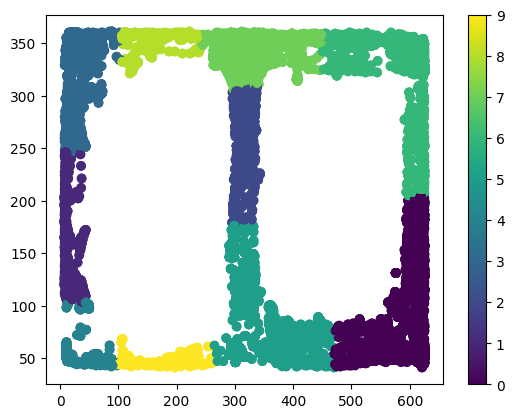

In [10]:
plt.scatter(y_test_pos[:, 0], y_test_pos[:, 1], c=y_test_kmeans)
#Add colorbar
plt.colorbar()

(array([15169.,  1636.,  3559.,  2211.,  2153.,  3205.,  2842.,  5827.,
          739.,   387.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

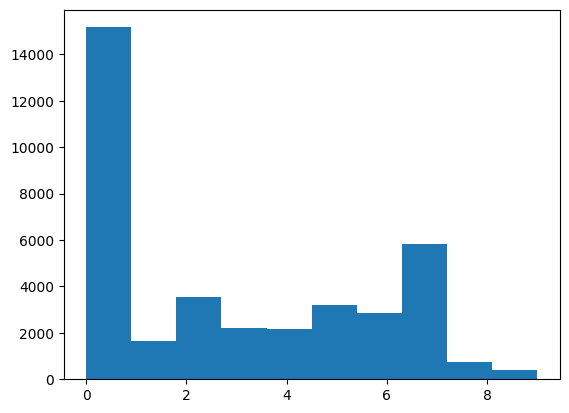

In [11]:
#Plot histogram of maze location
plt.figure()
plt.hist(y_test_kmeans, bins=10)

(array([ 3673.,  1130.,  2836.,  4793., 10701.,  2092.,   202., 10940.,
         1244.,   117.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

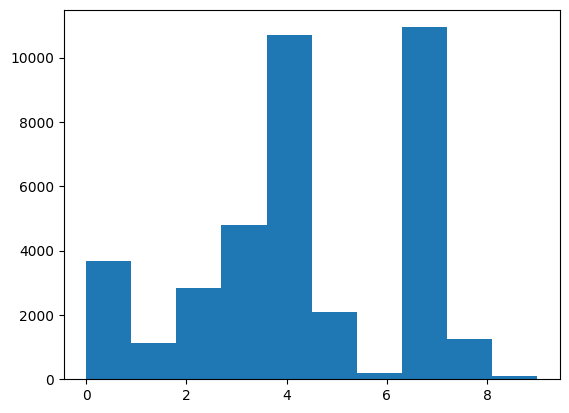

In [12]:
plt.figure()
plt.hist(y_pred_test, bins=10)

In [13]:
#Compute accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_kmeans, y_pred_test)
print("Accuracy: ", accuracy)

Accuracy:  0.27014418999151824


In [26]:
#Reshape predictions to be by group
y_pred_test_by_group = []
y_test_kmeans_by_group = []
for group in test_groups.unique():
    pred_counts = np.unique(y_pred_test[test_groups == group], return_counts=True)
    #Fill in missing values with zero
    pred_counts = dict(zip(pred_counts[0], pred_counts[1]))
    for i in range(10):
        if i not in pred_counts:
            pred_counts[i] = 0
    #Normalize
    pred_counts = {k: v/sum(pred_counts.values()) for k, v in pred_counts.items()}
    y_pred_test_by_group.append([v[1] for v in sorted(pred_counts.items())])

    #Do the same for the true values
    keamns_counts = np.unique(y_test_kmeans[test_groups == group], return_counts=True)
    keamns_counts = dict(zip(keamns_counts[0], keamns_counts[1]))
    for i in range(10):
        if i not in keamns_counts:
            keamns_counts[i] = 0
    keamns_counts = {k: v/sum(keamns_counts.values()) for k, v in keamns_counts.items()}
    y_test_kmeans_by_group.append([v[1] for v in sorted(keamns_counts.items())])


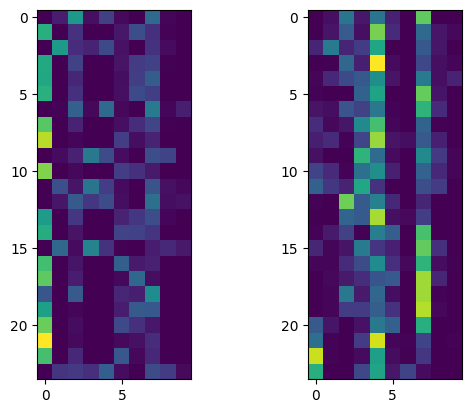

In [27]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(y_test_kmeans_by_group)
axes[1].imshow(y_pred_test_by_group)


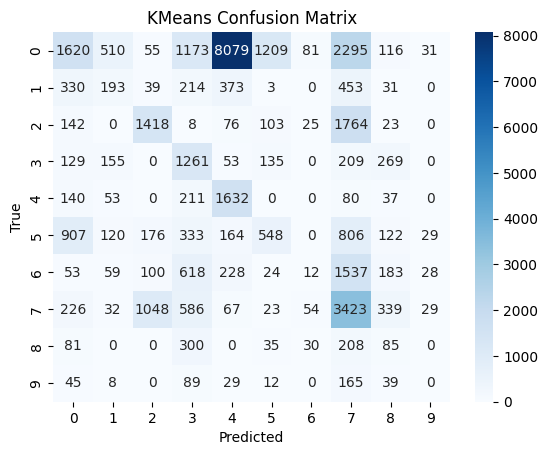

In [14]:
import numpy as np
import matplotlib.pyplot as plt

#Plot a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax)
    ax.set(xlabel='Predicted', ylabel='True', xticklabels=classes, yticklabels=classes)
    if title:
        ax.set_title(title)
    return fig, ax

#Plot the confusion matrix
fig, ax = plot_confusion_matrix(y_test_kmeans, y_pred_test, classes=np.arange(10), title='KMeans Confusion Matrix')


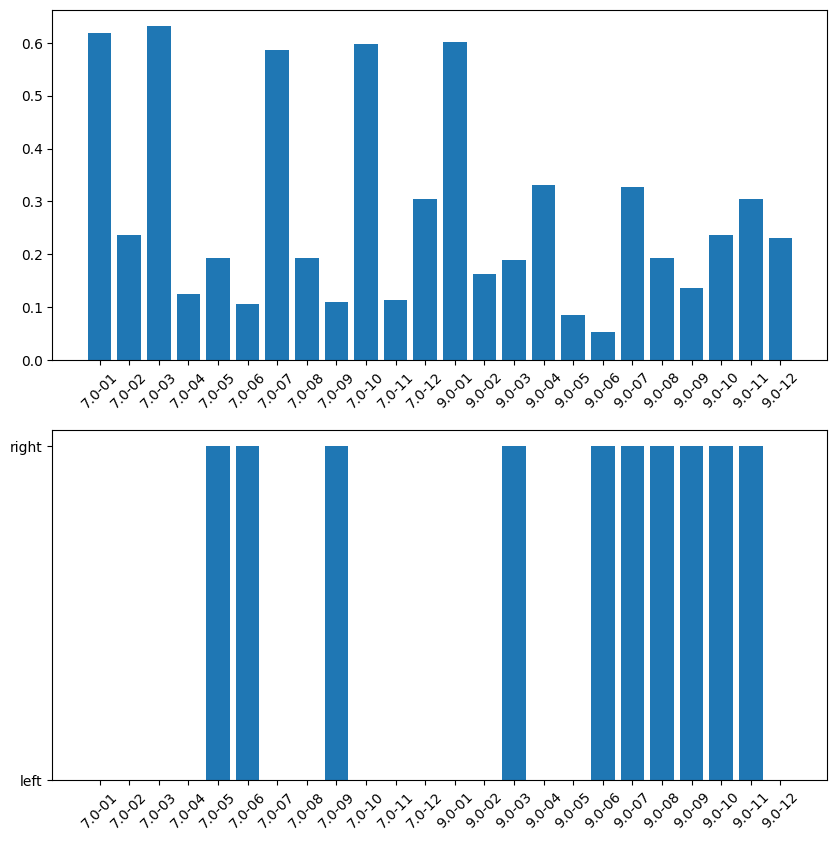

In [33]:
#Plot test_accuracy_by_group
import matplotlib.pyplot as plt
import seaborn as sns

keys, vals = zip(*test_accuracy_by_group.items())
trial_names = [k.split('Rds-')[1] for k in keys]
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].bar(range(len(test_accuracy_by_group)), vals)
#Change x labels to be the keys
ax[0].set_xticks(range(len(test_accuracy_by_group)), trial_names, rotation=45);

#Plot the maze choice for each group
maze_choices = list(group_to_maze_choice.items())
ax[1].bar(range(len(maze_choices)), [v[1] for v in maze_choices])
ax[1].set_xticks(range(len(maze_choices)), [v[0] for v in maze_choices], rotation=45);

In [6]:
def train_logo(df_all, reward = 'right'):

    df_cis = df_all[df_all['Reward'] == reward]
    df_cis['group'] = df_cis['filename'] + df_cis['Session'].astype(str) + df_cis['Trial Number'].astype(str)

    #Take a random sample of the data
    df = df_cis.sample(n=N_ROWS, random_state=42)

    #Turn into wide table, by cell type and dff signal
    df_wide = df.pivot(index=['group', 'Centre position X', 'Centre position Y', 'frame'], columns='MatchID', values='dff').reset_index()
    df_wide.columns = list(df_wide.columns[:4]) + [f'Cell_{i}' for i in df_wide.columns[4:]]
    #df_wide = df_wide.dropna()
    df_wide = df_wide.fillna(0)
    y = df_wide[['Centre position X', 'Centre position Y']].values
    X = df_wide.iloc[:,4:].values

    groups = df_wide['group'].values
    logo = LeaveOneGroupOut()

    train_accs = []
    test_accs = []
    train_accs_shuffled = []
    test_accs_shuffled = []

    # #For each group, do the whole split, training and evaluation 
    for train_index, test_index in logo.split(X, y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        pca = PCA(n_components=100)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        kmeans = KMeans(n_clusters=10, random_state=0).fit(y_train)
        y_train_kmeans = kmeans.predict(y_train)
        y_test_kmeans = kmeans.predict(y_test)
        
        #try logistic regression 
        clf = LogisticRegression(random_state=42)
        clf.fit(X_train_pca, y_train_kmeans)
        
        y_pred_train = clf.predict(X_train_pca)
        y_pred_test = clf.predict(X_test_pca)
        
        #Evaluate
        train_accuracy = accuracy_score(y_train_kmeans, y_pred_train)
        test_accuracy = accuracy_score(y_test_kmeans, y_pred_test)
        
        test_accs.append(test_accuracy)
        train_accs.append(train_accuracy)

        #try logistic regression with shuffled labels
        # clf = LogisticRegression(random_state=42)
        #Shuffle the labels
        # np.random.shuffle(y_train_kmeans)
        # clf.fit(X_train_pca, y_train_kmeans)
        
        n_resamples = 50

        train_accs_shuffled_og = []
        test_accs_shuffled_og = []

        for i in tqdm(range(n_resamples)):
            np.random.shuffle(y_train_kmeans)
            np.random.shuffle(y_test_kmeans)
            train_accuracy = accuracy_score(y_train_kmeans, y_pred_train)
            test_accuracy = accuracy_score(y_test_kmeans, y_pred_test)
            train_accs_shuffled_og.append(train_accuracy)
            test_accs_shuffled_og.append(test_accuracy)    
                
        train_accs_shuffled.append(np.mean(train_accs_shuffled_og))
        test_accs_shuffled.append(np.mean(test_accs_shuffled_og))
        
    print("Train accuracy: ", np.mean(train_accs))
    print("Test accuracy: ", np.mean(test_accs))
    print("Test accuracy shuffled", np.mean(test_accs_shuffled))

    results = {'train_accs': train_accs, 'test_accs': test_accs, 'test_accs_shuffled': test_accs_shuffled}
    return results

In [8]:
# results_left = train_logo(df, reward='left')
# results_left

In [7]:
def train_one_side_test_other(df_all, train_reward = 'right'):

    df_all['group'] = df_all['filename'] + df_all['Session'].astype(str) + df_all['Trial Number'].astype(str)

    #Turn into wide table, by cell type and dff signal
    index_cols = ['group', 'Reward', 'Centre position X', 'Centre position Y', 'frame']
    df_wide = df_all.pivot(index=index_cols, columns='MatchID', values='dff').reset_index()
    df_wide.columns = list(df_wide.columns[:len(index_cols)]) + [f'Cell_{i}' for i in df_wide.columns[len(index_cols):]]
    df_wide = df_wide.fillna(0)
    y = df_wide[['Centre position X', 'Centre position Y']].values
    X = df_wide.iloc[:,len(index_cols):].values
    train_index = df_wide[df_wide['Reward'] == train_reward].index
    train_index = np.random.choice(train_index, N_ROWS, replace=True)
    test_index = df_wide[df_wide['Reward'] != train_reward].index

    train_accs = []
    test_accs = []
    train_accs_shuffled = []
    test_accs_shuffled = []

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pca = PCA(n_components=100)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    kmeans = KMeans(n_clusters=10, random_state=0).fit(y_train)
    y_train_kmeans = kmeans.predict(y_train)
    y_test_kmeans = kmeans.predict(y_test)
    
    #try logistic regression 
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train_pca, y_train_kmeans)
    
    y_pred_train = clf.predict(X_train_pca)
    y_pred_test = clf.predict(X_test_pca)
    
    #Evaluate
    train_accuracy = accuracy_score(y_train_kmeans, y_pred_train)
    test_accuracy = accuracy_score(y_test_kmeans, y_pred_test)
    
    test_accs.append(test_accuracy)
    train_accs.append(train_accuracy)

    n_resamples = 50
    train_accs_shuffled_og = []
    test_accs_shuffled_og = []
    for i in tqdm(range(n_resamples)):
        np.random.shuffle(y_train_kmeans)
        np.random.shuffle(y_test_kmeans)
        train_accuracy = accuracy_score(y_train_kmeans, y_pred_train)
        test_accuracy = accuracy_score(y_test_kmeans, y_pred_test)
        train_accs_shuffled_og.append(train_accuracy)
        test_accs_shuffled_og.append(test_accuracy)    
            
    train_accs_shuffled.append(np.mean(train_accs_shuffled_og))
    test_accs_shuffled.append(np.mean(test_accs_shuffled_og))
        
    print("Train accuracy: ", np.mean(train_accs))
    print("Test accuracy: ", np.mean(test_accs))
    print("Test accuracy shuffled", np.mean(test_accs_shuffled))

    results = {'train_accs': train_accs, 'test_accs': test_accs, 'test_accs_shuffled': test_accs_shuffled}
    return results

In [6]:
results = train_one_side_test_other(df, train_reward='left')

/home/blansdel/.conda/envs/ethome/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
y, y_train, y_test = results

In [12]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(y_train)
y_train_kmeans = kmeans.predict(y_train)
y_test_kmeans = kmeans.predict(y_test)

/home/blansdel/.conda/envs/ethome/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


: 

In [24]:
index_cols = ['group', 'Reward', 'Centre position X', 'Centre position Y', 'frame']
len(list(results.columns[:len(index_cols)]) + [f'Cell_{i}' for i in results.columns[len(index_cols):]])

119

In [28]:
results

,group,Reward,Centre position X,Centre position Y,frame,Cell_10,Cell_101,Cell_103,Cell_104,Cell_105,...,Cell_85,Cell_86,Cell_87,Cell_88,Cell_89,Cell_91,Cell_94,Cell_97,Cell_98,Cell_99
0,final_010713.Rds2.01,left,9.0,153.0,1464,-0.009779,0.344782,-0.330636,-0.046223,0.032526,...,0.003806,-0.003086,0.000000,-0.054344,0.108039,0.174601,0.313400,0.364912,0.057359,-0.100857
1,final_010713.Rds2.01,left,9.0,153.0,1465,-0.012320,0.367885,-0.330931,-0.047508,0.031801,...,-0.000490,0.011818,0.000000,-0.054344,0.097887,0.248847,0.313181,0.383360,0.052396,-0.102494
2,final_010713.Rds2.01,left,9.0,172.0,1466,-0.014728,0.348712,-0.331214,-0.042913,0.027911,...,-0.004518,0.022702,0.000000,-0.054344,0.088234,0.233182,0.398578,0.378339,0.047695,-0.104055
3,final_010713.Rds2.01,left,9.0,172.0,1467,-0.017009,0.338356,-0.331485,-0.044374,0.024231,...,-0.008295,0.017345,0.000000,-0.054344,0.079056,0.249224,0.420590,0.366599,0.043243,-0.105542
4,final_010713.Rds2.01,left,9.0,184.0,1468,-0.019171,0.345082,-0.331744,-0.045757,0.031664,...,-0.011835,0.015338,0.000000,-0.054344,0.070329,0.322972,0.405636,0.350255,0.048720,-0.106959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75010,final_010721.Rds9.09,right,625.0,253.0,14457,0.013590,0.300610,0.306346,0.103546,-0.069179,...,-0.018260,0.330701,0.005922,0.063268,0.104423,-0.203619,0.012799,0.020766,-0.028354,-0.041755
75011,final_010721.Rds9.09,right,625.0,255.0,15239,0.027877,-0.060108,0.221632,0.047150,0.061683,...,0.025072,0.183672,0.143533,0.030132,0.038627,0.279447,-0.169892,-0.021547,-0.062280,-0.043303
75012,final_010721.Rds9.09,right,625.0,255.0,15240,0.035241,-0.062659,0.220226,0.044095,0.071649,...,0.020738,0.171560,0.144009,0.044162,0.033181,0.256554,-0.173605,-0.022692,-0.062904,-0.043305
75013,final_010721.Rds9.09,right,625.0,348.0,14412,-0.029475,-0.013826,0.308164,0.093804,-0.033913,...,-0.039111,0.341103,0.022168,-0.004581,-0.035486,-0.175913,-0.051103,0.168319,0.122113,-0.038792


In [27]:
y = results[['Centre position X', 'Centre position Y']].values
X = results.iloc[:,len(index_cols):].values


In [29]:
train_index = results[results['Reward'] == 'left'].index
train_index = np.random.choice(train_index, N_ROWS, replace=True)
test_index = results[results['Reward'] != 'left'].index

train_accs = []
test_accs = []
train_accs_shuffled = []
test_accs_shuffled = []

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]


In [30]:
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

kmeans = KMeans(n_clusters=10, random_state=0).fit(y_train)
y_train_kmeans = kmeans.predict(y_train)
y_test_kmeans = kmeans.predict(y_test)

#try logistic regression 
clf = LogisticRegression(random_state=42)
clf.fit(X_train_pca, y_train_kmeans)

y_pred_train = clf.predict(X_train_pca)
y_pred_test = clf.predict(X_test_pca)


/home/blansdel/.conda/envs/ethome/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


: 